In [1]:
import numpy as np
import soundfile
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
# FBCFNOMOD
# This function creates a feedback comb filter by processing an individual
# input sample and updating a delay buffer used in a loop to index each
# sample in a signal. This implementation does not use fractional delay.
# Therefore, the delay time cannot be modulated.
#
# Input Variables
#   n: current sample number of the input sample
#   delay: samples of delay
#   fbGain: feedback gain (linear scale)
#
# See also FBCF

def fbcfNoMod(x, buffer, n, delay, fbGain):
    # Determine indexes for circular buffer
    M = len(buffer)
    indexC = np.mod(n, M) # Current index
    indexD = int(np.mod((n - delay)), M) # Delay index

    out = buffer[indexD]

    # Store the current output in appropriate index
    buffer[indexC] = x + fbGain * buffer[indexD]

    return out, buffer

In [3]:
# FBCF
# This function creates a feedback comb filter by processing an
# individual input sample and updating a delay buffer used in a loop
# to index each sample in a signal. Fractional delay is implemented
# to make it possible to modulate the delay time.
#
# Input Variables
#   n: current sample number of the input sample
#   delay: samples of delay
#   fbGain: feedback gain (linear scale)
#   amp: amplitude of LFO modulation
#   rate: frequency of LFO modulation
#
# See also FBCFNOMOD

def fbcf(x, buffer, Fs, n, delay, fbGain, amp, rate):
    # Calculate time in seconds for the current sample
    t = n/Fs
    fracDelay = amp * np.sin(2 * np.pi * rate * t)
    intDelay = int(np.floor(fracDelay))
    frac = fracDelay - intDelay

    # Determine indexes for circular buffer
    M = len(buffer)
    indexC = int(np.mod(n, M)) # Current index
    indexD = int(np.mod((n-delay+intDelay), M)) # Delay index
    indexF = int(np.mod((n-delay+intDelay+1), M)) # Fractional index

    out = (1 - frac) * buffer[indexD] + frac * buffer[indexF]

    # Store the current output in appropriate index
    buffer[indexC] = x + fbGain * out

    return out, buffer

In [4]:
# FBCFEXAMPLE
# This script uses a feedback comb filter (FBCF) function applied
# to an acoustic guitar recording.
#
# See also FBCFNOMOD, FBCF

x, Fs = soundfile.read('AcGtr.wav')

maxDelay = int(np.ceil(0.05 * Fs)) # maximum delay of 50ms
buffer = np.zeros(maxDelay) # initialize delay buffer

d = 0.04 * Fs # 40ms of delay
g = -0.7 # feedback gain value

rate = 0.6 # Hz (frequency of LFO)
amp = 6 # Range of +/- 6 samples for delay

# Initialize output signal
N = len(x)
out = np.zeros(N)

for n in range(N):

    # Uncomment to use fbcfNoMod function
    # out[n], buffer = fbcfNoMod(x[n], buffer, n, d, g)

    # Use fbcf function
    out[n], buffer = fbcf(x[n], buffer, Fs, n, d, g, amp, rate)

Audio(out, rate=Fs)

In [5]:
# FBCFSERIESEXAMPLE
# This script uses series feedback comb filter (FBCF) functions, applied to
# an acoustic guitar recording.
#
# See also FBCFPARALLELEXAMPLE

x, Fs = soundfile.read('AcGtr.wav')

maxDelay = int(np.ceil(0.07 * Fs))  # max delay of 70ms
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay)

d1 = np.fix(0.042 * Fs) # 42ms of delay
g1 = 0.5
d2 = np.fix(0.053 * Fs) # 53ms of delay
g2 = -0.5

rate1 = 0.6 # Hz (frequency of LFO)
amp1 = 6 # Range of +/- 6 samples for delay
rate2 = 0.5 # Hz (frequency of LFO)
amp2 = 8 # Range of +/- 8 samples for delay

# Initialize output signal
N = len(x)
out = np.zeros(N)

for n in range(N):

    # Two series FBCFs
    w, buffer1 = fbcf(x[n], buffer1, Fs, n, d1, g1, amp1, rate1)

    # The output 'w' of the first FBCF is used as the input
    # of the second FBCF
    out[n], buffer2 = fbcf(w, buffer2, Fs, n, d2, g2, amp2, rate2)

Audio(out, rate=Fs)

In [6]:
# FBCFPARALLELEXAMPLE
# This script uses parallel feedback comb filter (FBCF) functions
# applied to an acoustic guitar recording.
#
# See also FBCFSERIESEXAMPLE

x, Fs = soundfile.read('AcGtr.wav')

maxDelay = int(np.ceil(0.07 * Fs)) # max delay of 70ms
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay)

d1 = np.fix(0.047 * Fs) # 47ms of delay
g1 = 0.5
d2 = np.fix(0.053 * Fs) # 53ms of delay
g2 = -0.5

rate1 = 0.6 # Hz (frequency of LFO)
amp1 = 6 # Range of +/- 6 samples for delay
rate2 = 0.5 # Hz (frequency of LFO)
amp2 = 8 # Range of +/- 8 samples for delay

# Initialize output signal
N = len(x)
out = np.zeros(N)

for n in range(N):
    # Two parallel FBCFs
    w1, buffer1 = fbcf(x[n], buffer1, Fs, n, d1, g1, amp1, rate1)

    # Both FBCF receive 'x' to create parallel processing
    w2, buffer2 = fbcf(x[n], buffer2, Fs, n, d2, g2, amp2, rate2)

    # The output of each FBCF is summed together to complete parallel processing
    out[n] = w1 + w2

Audio(out, rate=Fs)

In [7]:
# APF
# This function creates an all-pass filter by processing an individual
# input sample and updating a delay buffer used in a loop to index each
# sample in a signal.
#
# Input Variables
#   n: current sample number of the input signal
#   delay: samples of delay
#   gain: feedback gain (linear scale)
#   amp: amplitude of LFO modulation
#   rate: frequency of LFO modulation

def apf(x, buffer, Fs, n, delay, gain, amp, rate):
    # Calculate time in seconds for the current sample
    t = n/Fs
    fracDelay = amp * np.sin(2 * np.pi * rate * t)
    intDelay = int(np.floor(fracDelay))
    frac = fracDelay - intDelay

    # Determine indexes for circular buffer
    M = len(buffer)
    indexC = int(np.mod(n, M)) # Current index
    indexD = int(np.mod((n-delay+intDelay), M)) # Delay index
    indexF = int(np.mod((n-delay+intDelay+1), M)) # Fractional index

    # Temp variable for output of delay buffer
    w = (1 - frac) * buffer[indexD] + frac * buffer[indexF]

    # Temp variable used for the node after the input sum
    v = x + (-gain * w)

    # Summation at output
    out = (gain * v) + w

    # Store the current input to delay buffer
    buffer[indexC] = v

    return out, buffer

In [8]:
# APFEXAMPLE
# This script uses an all-pass filter function applied to an acoustic
# guitar recording.
#
# See also APF

x, Fs = soundfile.read('AcGtr.wav')

maxDelay = int(np.ceil(0.05 * Fs)) # maximum delay of 50ms
buffer = np.zeros(maxDelay)

d = np.ceil(0.042 * Fs) # 42ms of delay
g = 0.9

rate = 0.9 # Hz (frequency of LFO)
amp = 6 # Range of +/- 6 samples for delay

# Initialize output signal
N = len(x)
out = np.zeros(N)

for n in range(N):
    # Use apf function
    out[n], buffer = apf(x[n], buffer, Fs, n, d, g, amp, rate)

Audio(out, rate=Fs)

In [9]:
# SCHROEDERREVERB
# This script implements the Schroeder reverb algorithm by using feedback
# comb filters (fbcf) and all-pass filters (apf).
#
# See also FBCF, APF

x, Fs = soundfile.read('AcGtr.wav')

# Max delay of 70ms
maxDelay = int(np.ceil(0.07 * Fs))
# Initialize all buffers (there are 6 total = 4 FBCFs, 2 APFs)
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay)
buffer3 = np.zeros(maxDelay)
buffer4 = np.zeros(maxDelay)
buffer5 = np.zeros(maxDelay)
buffer6 = np.zeros(maxDelay)

# Delay and gain parameters
d1 = np.fix(0.0297 * Fs)
g1 = 0.75
d2 = np.fix(0.0371 * Fs)
g2 = -0.75
d3 = np.fix(0.0411 * Fs)
g3 = 0.75
d4 = np.fix(0.0437 * Fs)
g4 = -0.75
d5 = np.fix(0.005 * Fs)
g5 = 0.7
d6 = np.fix(0.0017 * Fs)
g6 = 0.7

# LFO parameters
rate1 = 0.6
amp1 = 8
rate2 = 0.71
amp2 = 8
rate3 = 0.83
amp3 = 8
rate4 = 0.95
amp4 = 8
rate5 = 1.07
amp5 = 8
rate6 = 1.19
amp6 = 8

# Initialize output signal
N = len(x)
out = np.zeros(N)

for n in range(N):
    # Four parallel FBCFs
    w1, buffer1 = fbcf(x[n], buffer1, Fs, n, d1, g1, amp1, rate1)
    w2, buffer2 = fbcf(x[n], buffer2, Fs, n, d2, g2, amp2, rate2)
    w3, buffer3 = fbcf(x[n], buffer3, Fs, n, d3, g3, amp3, rate3)
    w4, buffer4 = fbcf(x[n], buffer4, Fs, n, d4, g4, amp4, rate4)

    # Combine parallel paths
    combPar = 0.25 * (w1 + w2 + w3 + w4)

    # Two series all-pass filters
    w5, buffer5 = apf(combPar, buffer5, Fs, n, d5, g5, amp5, rate5)
    out[n], buffer6 = apf(w5, buffer6, Fs, n, d6, g6, amp6, rate6)

Audio(out, rate=Fs)

In [22]:
# EARLYREFLECTIONS
# This function creates a tapped delay line to be used for the early
# reflections of a reverb algorithm. THe delays and gains of the taps
# are included in this function and were based on an IR measurement from a
# recording studio in Nashville, TN.
#
# Also see MOORERREVERB

def earlyReflections(x, buffer, Fs, n):

    # Delay times converted from milliseconds
    delayTimes = [np.fix(0*Fs), np.fix(0.01277*Fs), np.fix(0.01283*Fs), np.fix(0.01293*Fs), np.fix(0.01333*Fs),
                              np.fix(0.01566*Fs), np.fix(0.02404*Fs), np.fix(0.02679*Fs), np.fix(0.02731*Fs), np.fix(0.02737*Fs), np.fix(0.02914*Fs),
                              np.fix(0.02920*Fs), np.fix(0.02981*Fs), np.fix(0.03389*Fs), np.fix(0.04518*Fs), np.fix(0.04522*Fs), np.fix(0.04527*Fs),
                              np.fix(0.05452*Fs), np.fix(0.06958*Fs)]

    numDelays = len(delayTimes)
    for delay in range(numDelays):
        delayTimes[delay] = int(delayTimes[delay])

    # There must be a 'gain' for each of the 'delayTimes'
    gains = [1, 0.1526, -0.4097, 0.2984, 0.1553, 0.1442,
             -0.3124, -0.4176, -0.9391, 0.6926, -0.5787, 0.5782,
             0.4206, 0.3958, 0.3450, -0.5361, 0.417, 0.1948, 0.1548]

    # Determine indexes for circular buffer
    M = len(buffer)
    indexC = np.mod(n, M) # current index
    buffer[indexC] = x

    out = 0 # initialize the output to be used in loop

    # Loop through all the taps
    for tap in range(len(delayTimes)):
        # Find the circular buffer index for the current tap
        indexTDL = np.mod(n-delayTimes[tap], M)

        # 'Tap' the delay line and add current tap with output
        out = out + gains[tap] * buffer[indexTDL]

    return out, buffer

In [23]:
# LPCF
# This function creates a feedback comb filter with a LPF in the feedback
# path.
#
# Input Variables
#   n: current sample number of the input signal
#   delay: samples of delay
#   fbGain: feedback gain (linear scale)
#   amp: amplitude of LFO modulation
#   rate: frequency of LFO modulation
#   fbLPF: output delayed one sample to create basic LPF
#
# See also MOORERREVERB

def lpcf(x, buffer, Fs, n, delay, fbGain, amp, rate, fbLPF):
    # Calculate time in seconds for the current sample
    t = n/Fs
    fracDelay = amp * np.sin(2 * np.pi * rate * t)
    intDelay = int(np.floor(fracDelay))
    frac = fracDelay - intDelay

    # Determine indexes for circular buffer
    M = len(buffer)
    indexC = int(np.mod(n, M))  # Current index
    indexD = int(np.mod((n - delay + intDelay), M))  # Delay index
    indexF = int(np.mod((n - delay + intDelay + 1), M))  # Fractional index

    out = (1 - frac) * buffer[indexD] + frac * buffer[indexF]

    # Store the current output in appropriate index. The LPF is created
    # by adding the current output with the previous sample, both are
    # weighted 0.5.
    buffer[indexC] = x + fbGain * (0.5 * out + 0.5 * fbLPF)

    # Store the current output for the feedback LPF to be used with the
    # next sample.
    fbLPF = out

    return out, buffer, fbLPF


In [24]:
# MOORERREVERB
# This script implements the Moorer reverb algorithm by modifying the
# Schroeder reverb script. First, an additional step to add early reflections
# is included. Second, a simple low-pass filter is included in the feedback
# path of the comb filters.
#
# See also EARLYREFLECTIONS, LPCF

x, Fs = soundfile.read('AcGtr.wav')
x = np.append(x, np.zeros(Fs*3)) # Add zero-padding for reverb tail

# Max delay of 70ms
maxDelay = int(np.ceil(0.07 * Fs))
# Initialize all buffers
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay)
buffer3 = np.zeros(maxDelay)
buffer4 = np.zeros(maxDelay)
buffer5 = np.zeros(maxDelay)
buffer6 = np.zeros(maxDelay)

# Early reflections tapped delay line
bufferER = np.zeros(maxDelay)

# Delay and gain parameters
d1 = np.fix(0.0297 * Fs)
g1 = 0.9
d2 = np.fix(0.0371 * Fs)
g2 = -0.9
d3 = np.fix(0.0411 * Fs)
g3 = 0.9
d4 = np.fix(0.0437 * Fs)
g4 = -0.9
d5 = np.fix(0.005 * Fs)
g5 = 0.7
d6 = np.fix(0.0017 * Fs)
g6 = 0.7

# LFO parameters
rate1 = 0.6
amp1 = 8
rate2 = 0.71
amp2 = 8
rate3 = 0.83
amp3 = 8
rate4 = 0.95
amp4 = 8
rate5 = 1.07
amp5 = 8
rate6 = 1.19
amp6 = 8

# Variables used as delay for a simple LPF in each comb filter function
fbLPF1 = 0
fbLPF2 = 0
fbLPF3 = 0
fbLPF4 = 0

# Initialize output signal
N = len(x)
out = np.zeros(N)

for n in range(N):
    # Early reflections TDL
    w0, bufferER = earlyReflections(x[n], bufferER, Fs, n)

    # Four parallel LPCFs
    w1, buffer1, fbLPF1 = lpcf(w0, buffer1, Fs, n, d1, g1, amp1, rate1, fbLPF1)
    w2, buffer2, fbLPF2 = lpcf(w0, buffer2, Fs, n, d2, g2, amp2, rate2, fbLPF2)
    w3, buffer3, fbLPF3 = lpcf(w0, buffer3, Fs, n, d3, g3, amp3, rate3, fbLPF3)
    w4, buffer4, fbLPF4 = lpcf(w0, buffer4, Fs, n, d4, g4, amp4, rate4, fbLPF4)

    # Combine parallel paths
    combPar = 0.25 * (w1 + w2 + w3 + w4)

    # Two series all-pass filters
    w5, buffer5 = apf(combPar, buffer5, Fs, n, d5, g5, amp5, rate5)
    out[n], buffer6 = apf(w5, buffer6, Fs, n, d6, g6, amp6, rate6)

Audio(out, rate=Fs)

In [25]:
# MODDELAY
# This function creates a series delay effect using a buffer. The delay
# time can be modulated based on the LFO parameters 'depth' and 'rate'.
#
# Input Variables
#   x: single sample of the input signal
#   buffer: used to store delayed samples of the signal
#   n: current sample used for the LFO
#   depth: range of modulation (samples)
#   rate: speed of modulation (frequency, Hz)

def modDelay(x, buffer, Fs, n, delay, depth, rate):
    # Calculate time in seconds for the current sample
    t = n/Fs
    fracDelay = depth * np.sin(2 * np.pi * rate * t)
    intDelay = int(np.floor(fracDelay))
    frac = fracDelay - intDelay

    # Determine indexes for circular buffer
    M = len(buffer)
    indexC = int(np.mod(n, M)) # Current index
    indexD = int(np.mod((n-delay+intDelay), M)) # Delay index
    indexF = int(np.mod((n-delay+intDelay+1), M)) # Fractional index

    out = (1-frac) * buffer[indexD] + frac * buffer[indexF]

    # Store the current output in appropriate index
    buffer[indexC] = x

    return out, buffer


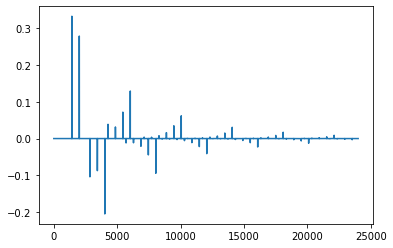

In [28]:
# CROSSOVERFEEDBACK
# This script implements two comb filters with crossover feedback.
#
# See also MODDELAY

Fs = 48000
x = np.append(1, np.zeros(int(Fs*0.5))) # Add zero-padding for reverb tail

# Max delay of 70ms
maxDelay = int(np.ceil(0.07 * Fs))
# Initialize all buffers
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay)

# Early reflections tapped delay line
bufferER = np.zeros(maxDelay)

# Delay and gain parameters
d1 = np.fix(0.0297 * Fs)
g11 = -0.75
g12 = -0.75
d2 = np.fix(0.0419 * Fs)
g21 = -0.75
g22 = -0.75

# LFO parameters
rate1 = 0.6
amp1 = 3
rate2 = 0.71
amp2 = 3

# Initialize output signal
N = len(x)
out = np.zeros(N)

fb1 = 0
fb2 = 0 # feedback holding variables

for n in range(N):
    # Combine input with feedback for respective delay lines
    xDL1 = x[n] + fb1
    xDL2 = x[n] + fb2


    # Two parallel delay lines
    outDL1, buffer1 = modDelay(xDL1, buffer1, Fs, n, d1, amp1, rate1)
    outDL2, buffer2 = modDelay(xDL2, buffer2, Fs, n, d2, amp2, rate2)

    # Combine parallel paths
    out[n] = 0.5 * (outDL1 + outDL2)

    # Calculate feedback (including crossover)
    fb1 = 0.5 * (g11 * outDL1 + g21 * outDL2)
    fb2 = 0.5 * (g12 * outDL2 + g22 * outDL2)

plt.plot(out)
plt.show()

Audio(out, rate=Fs)

In [29]:
# FDNEXAMPLE
# This script implements a feedback delay network using a Stautner and
# Puckette matrix.
#
# See also MODDELAY

x, Fs = soundfile.read('AcGtr.wav')
# Add extra space at the end for the reverb tail
x = np.append(x, np.zeros(Fs * 3))

# Max delay of 70ms
maxDelay = int(np.ceil(0.07 * Fs))
# Initialize all buffers
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay)
buffer3 = np.zeros(maxDelay)
buffer4 = np.zeros(maxDelay)

d1 = np.fix(0.0297 * Fs)
d2 = np.fix(0.0371 * Fs)
d3 = np.fix(0.0411 * Fs)
d4 = np.fix(0.0437 * Fs)

# Stautner and Puckette feedback matrix
g11 = 0
g12 = 1
g13 = 1
g14 = 0
g21 = -1
g22 = 0
g23 = 0
g24 = -1
g31 = 1
g32 = 0
g33 = 0
g34 = -1
g41 = 0
g42 = 1
g43 = -1
g44 = 0

# LFO parameters
rate1 = 0.6
amp1 = 5
rate2 = 0.71
amp2 = 5
rate3 = 0.83
amp3 = 5
rate4 = 0.95
amp4 = 5

# Initialize output signal
N = len(x)
out = np.zeros(N)

# Feedback holding variables
fb1 = 0
fb2 = 0
fb3 = 0
fb4 = 0

# Gain to control reverb time
g = 0.67

for n in range(N):
    # Combine input with feedback for respective delay lines
    xDL1 = x[n] + fb1
    xDL2 = x[n] + fb2
    xDL3 = x[n] + fb3
    xDL4 = x[n] + fb4

    # Four parallel delay lines
    outDL1, buffer1 = modDelay(xDL1, buffer1, Fs, n, d1, amp1, rate1)
    outDL2, buffer2 = modDelay(xDL2, buffer2, Fs, n, d2, amp2, rate2)
    outDL3, buffer3 = modDelay(xDL3, buffer3, Fs, n, d3, amp3, rate3)
    outDL4, buffer4 = modDelay(xDL4, buffer4, Fs, n, d4, amp4, rate4)

    # Combine parallel paths
    out[n] = 0.25 * (outDL1 + outDL2 + outDL3 + outDL4)

    # Calculate feedback (including crossover)
    fb1 = g * (g11*outDL1 + g12*outDL2 + g13*outDL3 + g14*outDL4)
    fb2 = g * (g21*outDL1 + g22*outDL2 + g23*outDL3 + g24*outDL4)
    fb3 = g * (g31*outDL1 + g32*outDL2 + g33*outDL3 + g34*outDL4)
    fb4 = g * (g41*outDL1 + g42*outDL2 + g43*outDL3 + g44*outDL4)

Audio(out, rate=Fs)

/var/folders/vs/l1t_wf8n20580_20pnqg7hfr0000gn/T/ipykernel_50125/919647365.py:87: RuntimeWarning: divide by zero encountered in log10
  plt.plot(t, 20 * np.log10(abs(out)))


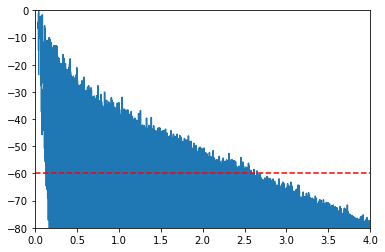

In [36]:
# RT60
# This script analyzes the RT-60 of a feedback delay network by visualizing
# an impulse response on the decibel scale.

Fs = 48000
Ts = 1/Fs
x = np.append(1, np.zeros(5 * Fs))

# Max delay of 70ms
maxDelay = int(np.ceil(0.07 * Fs))
# Initialize all buffers
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay)
buffer3 = np.zeros(maxDelay)
buffer4 = np.zeros(maxDelay)

d1 = np.fix(0.0297 * Fs)
d2 = np.fix(0.0371 * Fs)
d3 = np.fix(0.0411 * Fs)
d4 = np.fix(0.0437 * Fs)

# Stautner and Puckette feedback matrix
g11 = 0
g12 = 1
g13 = 1
g14 = 0
g21 = -1
g22 = 0
g23 = 0
g24 = -1
g31 = 1
g32 = 0
g33 = 0
g34 = -1
g41 = 0
g42 = 1
g43 = -1
g44 = 0

# LFO parameters
rate1 = 0.6
amp1 = 5
rate2 = 0.71
amp2 = 5
rate3 = 0.83
amp3 = 5
rate4 = 0.95
amp4 = 5

# Initialize output signal
N = len(x)
out = np.zeros(N)

fb1 = 0
fb2 = 0
fb3 = 0
fb4 = 0

# Gain to control reverb time
g = 0.67

for n in range(N):
    # Combine input with feedback for respective delay lines
    xDL1 = x[n] + fb1
    xDL2 = x[n] + fb2
    xDL3 = x[n] + fb3
    xDL4 = x[n] + fb4

    # Four parallel delay lines
    outDL1, buffer1 = modDelay(xDL1, buffer1, Fs, n, d1, amp1, rate1)
    outDL2, buffer2 = modDelay(xDL2, buffer2, Fs, n, d2, amp2, rate2)
    outDL3, buffer3 = modDelay(xDL3, buffer3, Fs, n, d3, amp3, rate3)
    outDL4, buffer4 = modDelay(xDL4, buffer4, Fs, n, d4, amp4, rate4)

    # Combine parallel paths
    out[n] = 0.25 * (outDL1 + outDL2 + outDL3 + outDL4)

    # Calculate feedback (including crossover)
    fb1 = g * (g11*outDL1 + g12*outDL2 + g13*outDL3 + g14*outDL4)
    fb2 = g * (g21*outDL1 + g22*outDL2 + g23*outDL3 + g24*outDL4)
    fb3 = g * (g31*outDL1 + g32*outDL2 + g33*outDL3 + g34*outDL4)
    fb4 = g * (g41*outDL1 + g42*outDL2 + g43*outDL3 + g44*outDL4)

out = out/max(abs(out)) # Normalize to unity gain (0 dB)

t = np.arange(0, N) * Ts
plt.plot(t, 20 * np.log10(abs(out)))
plt.axhline(-60, color='red', linestyle='--')
plt.axis([0, 4, -80, 0])
plt.show()
